<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/gp_spectral_mixture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectral mixture kernel in 1d for GP

https://tinygp.readthedocs.io/en/latest/tutorials/kernels.html#example-spectral-mixture-kernel

In this section, we will implement the "spectral mixture kernel" proposed by [Gordon Wilson & Adams (2013)](https://arxiv.org/abs/1302.4245).

In [1]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp

try:
    import optax
except ImportError:
    %pip install -q optax

     |████████████████████████████████| 126 kB 25.3 MB/s 
     |████████████████████████████████| 65 kB 4.4 MB/s 


In [2]:
import tinygp
import jax
import jax.numpy as jnp


class SpectralMixture(tinygp.kernels.Kernel):
    def __init__(self, weight, scale, freq):
        self.weight = jnp.atleast_1d(weight)
        self.scale = jnp.atleast_1d(scale)
        self.freq = jnp.atleast_1d(freq)

    def evaluate(self, X1, X2):
        tau = jnp.atleast_1d(jnp.abs(X1 - X2))[..., None]
        return jnp.sum(
            self.weight
            * jnp.prod(
                jnp.exp(-2 * jnp.pi**2 * tau**2 / self.scale**2) * jnp.cos(2 * jnp.pi * self.freq * tau),
                axis=-1,
            )
        )

Now let's implement the  simulate some data from this model:

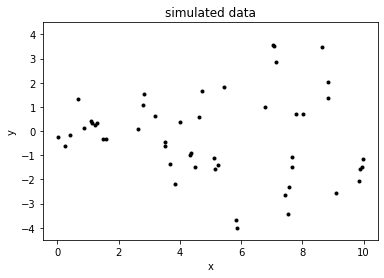

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def build_gp(theta):
    kernel = SpectralMixture(
        jnp.exp(theta["log_weight"]),
        jnp.exp(theta["log_scale"]),
        jnp.exp(theta["log_freq"]),
    )
    return tinygp.GaussianProcess(kernel, t, diag=jnp.exp(theta["log_diag"]), mean=theta["mean"])


params = {
    "log_weight": np.log([1.0, 1.0]),
    "log_scale": np.log([10.0, 20.0]),
    "log_freq": np.log([1.0, 1.0 / 3.0]),
    "log_diag": np.log(0.1),
    "mean": 0.0,
}

random = np.random.default_rng(546)
t = np.sort(random.uniform(0, 10, 50))
true_gp = build_gp(params)
y = true_gp.sample(jax.random.PRNGKey(123))

plt.plot(t, y, ".k")
plt.ylim(-4.5, 4.5)
plt.title("simulated data")
plt.xlabel("x")
_ = plt.ylabel("y")

One thing to note here is that we've used named parameters in a dictionary, instead of an array of parameters as in some of the other examples.
This would be awkward (but not impossible) to fit using `scipy`, so instead we'll use [`optax`](https://github.com/deepmind/optax) for optimization:

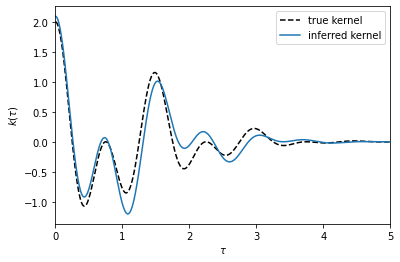

In [4]:
import optax


@jax.jit
@jax.value_and_grad
def loss(theta):
    return -build_gp(theta).condition(y)


opt = optax.sgd(learning_rate=3e-4)
opt_state = opt.init(params)
for i in range(1000):
    loss_val, grads = loss(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

opt_gp = build_gp(params)
tau = np.linspace(0, 5, 500)
plt.plot(tau, true_gp.kernel(tau[:1], tau)[0], "--k", label="true kernel")
plt.plot(tau, opt_gp.kernel(tau[:1], tau)[0], label="inferred kernel")
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$k(\tau)$")
_ = plt.xlim(tau.min(), tau.max())

plt.savefig("gp-spectral-mixture-learned-kernel.pdf")

Using our optimized model, over-plot the conditional predictions:

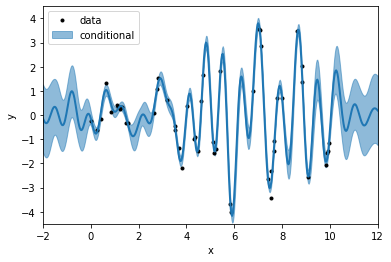

In [5]:
x = np.linspace(-2, 12, 500)
plt.plot(t, y, ".k", label="data")
mu, var = opt_gp.predict(y, x, return_var=True)
plt.fill_between(
    x,
    mu + np.sqrt(var),
    mu - np.sqrt(var),
    color="C0",
    alpha=0.5,
    label="prediction",
)
plt.plot(x, mu, color="C0", lw=2)
plt.xlim(x.min(), x.max())
plt.ylim(-4.5, 4.5)
plt.legend(loc=2)
plt.xlabel("x")
_ = plt.ylabel("y")


plt.savefig("gp-spectral-mixture-pred.pdf")